In [1]:
import plotly.express as px
from tinyshift.series import trend_significance
from utilsforecast.preprocessing import fill_gaps
from tinyshift.plot import corr_heatmap
import plotly.express as px
from utils import remove_leading_zeros, is_obsolete, forecastability, stationarity_check, generate_lag, add_fourier_seasonality, seasonal_decompose
import holidays
import pandas as pd
import numpy as np

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
df = pd.read_csv(url, parse_dates=['Month'])
df["unique_id"] = "1"
df.rename(columns={"Month": "ds", "Passengers": "y"}, inplace=True)

In [3]:
df.isnull().sum()

ds           0
y            0
unique_id    0
dtype: int64

In [4]:
df

,ds,y,unique_id
0,1949-01-01,112,1
1,1949-02-01,118,1
2,1949-03-01,132,1
3,1949-04-01,129,1
4,1949-05-01,121,1
...,...,...,...
139,1960-08-01,606,1
140,1960-09-01,508,1
141,1960-10-01,461,1
142,1960-11-01,390,1


In [5]:
df = fill_gaps(df, freq="ME", end="per_serie", id_col="unique_id", time_col="ds")

In [6]:
df = df.groupby("unique_id")[df.columns].apply(remove_leading_zeros).reset_index(drop=True)

In [7]:
days_obsoletes=180
obsolete_series = df.groupby("unique_id")[df.columns].apply(is_obsolete, days_obsoletes)

In [8]:
obsolote_ids = obsolete_series[obsolete_series].index.tolist()

In [9]:
obsolote_ids

[]

In [10]:
df.groupby("unique_id")["y"].apply(trend_significance)

unique_id
1    (0.853638165603188, 4.020274506593391e-61)
Name: y, dtype: object

In [11]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [12]:
px.line(df, x="ds", y="y", facet_col="unique_id")

In [13]:
df.groupby("unique_id")["y"].apply(forecastability)

unique_id                   
1          foreCA                                               0.571263
           theoretical_limit                                    0.086973
           stability_index                                      0.183962
           adi_cv                             (1.0, 0.18190737443351804)
           hurst_exponent       (0.5203628364992473, 0.8044229708616066)
Name: y, dtype: object

# ADF Test - Order of Diff 1

In [14]:
df["lag_1"] = generate_lag(df["y"], lag=1)
df["lag_12"] = generate_lag(df["lag_1"], lag=12)
#df = df.dropna()

In [15]:
df

,unique_id,ds,y,lag_1,lag_12
0,1,1949-01-01,112,NaN,NaN
1,1,1949-02-01,118,6.0,NaN
2,1,1949-03-01,132,14.0,NaN
3,1,1949-04-01,129,-3.0,NaN
4,1,1949-05-01,121,-8.0,NaN
...,...,...,...,...,...
139,1,1960-08-01,606,-16.0,-27.0
140,1,1960-09-01,508,-98.0,-2.0
141,1,1960-10-01,461,-47.0,9.0
142,1,1960-11-01,390,-71.0,-26.0


In [16]:
#df.groupby("unique_id")["lag_1"].apply(adfuller)

# Domingo

- #TODO: Adicionar gráfico de STL
- #TODO: Interpretar
- #TODO: Adicionar gráficos da aula do valeriy
- #TODO: Comparativo de dados diferenciados
- #TODO: Trazer gráficos de ipynbs dele

In [17]:
stationarity_check(df[["y", "lag_1", "lag_12"]], fig_type="png")

UnboundLocalError: local variable 'subplot_titles' referenced before assignment

In [21]:
df[["y", "lag_1", "lag_12"]].shape[1]

3

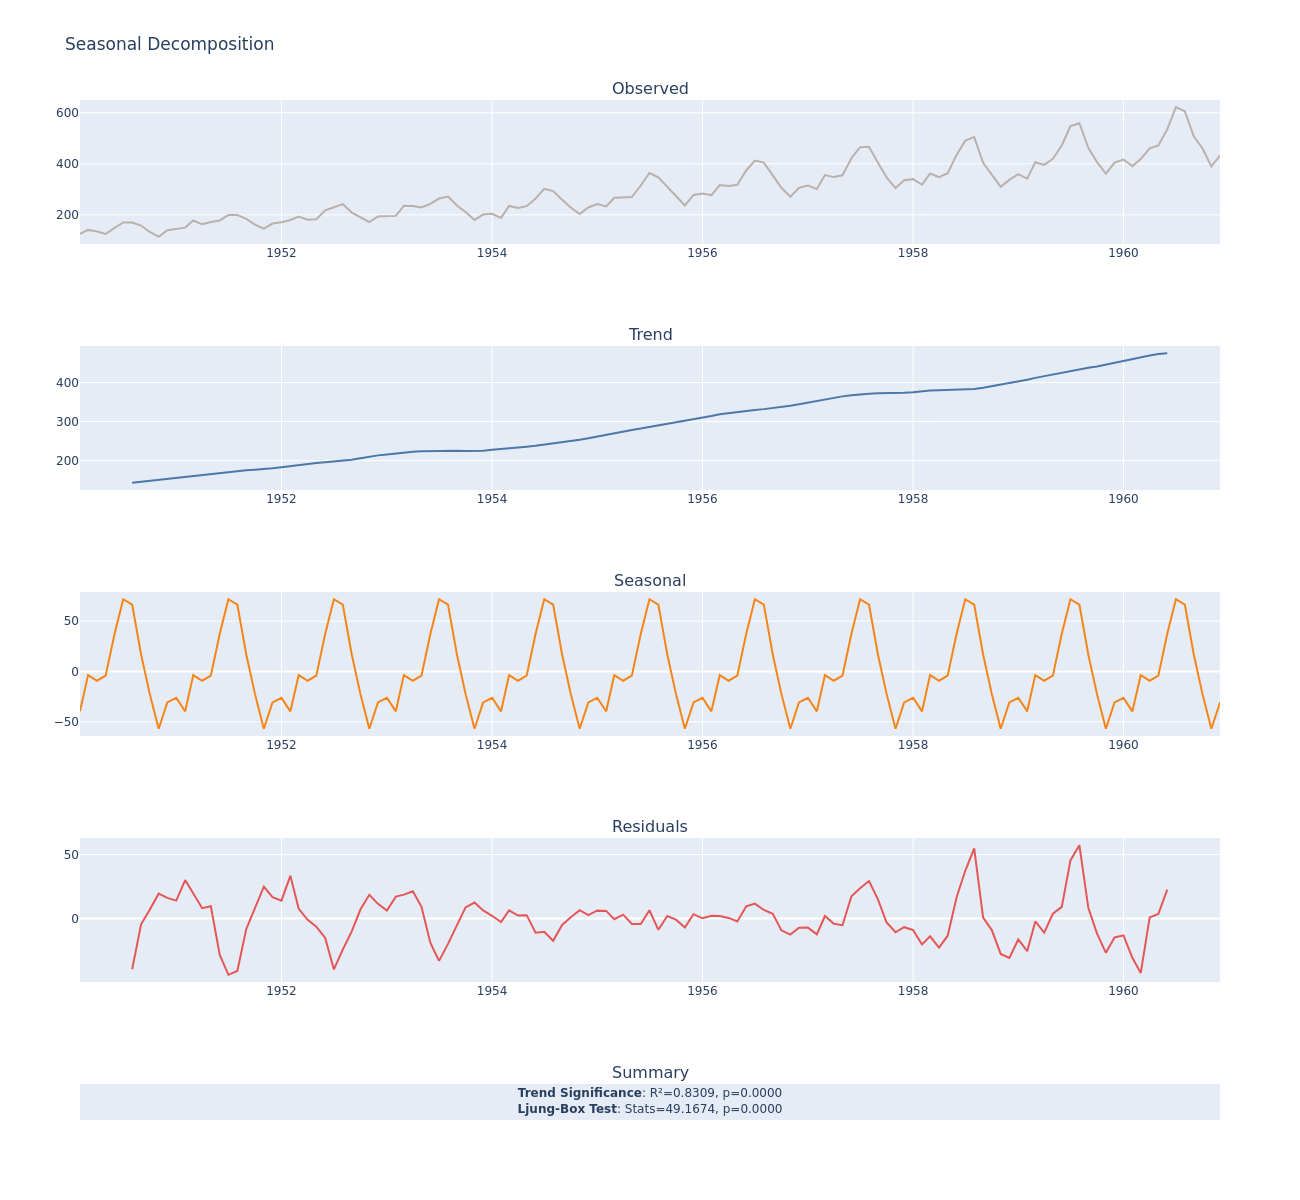

In [22]:
plot_seasonal_decompose(df.set_index("ds")["y"], fig_type="png", ljungbox_lags=1)

## Features
- ~~STL~~
- ~~Holidays~~
- ~~Série de fourier para padrões cíclicos (seno e cosseno) - dia da semana, dia do ano~~
- ~~mês~~
- ~~fim do mês~~
- ~~Lags~~
- Rolling Windows: médias, desvio padrão e permutação da entropia

In [19]:
df = add_fourier_seasonality(df, "ds", seasonality=["monthly"])

In [20]:
df = df.dropna()

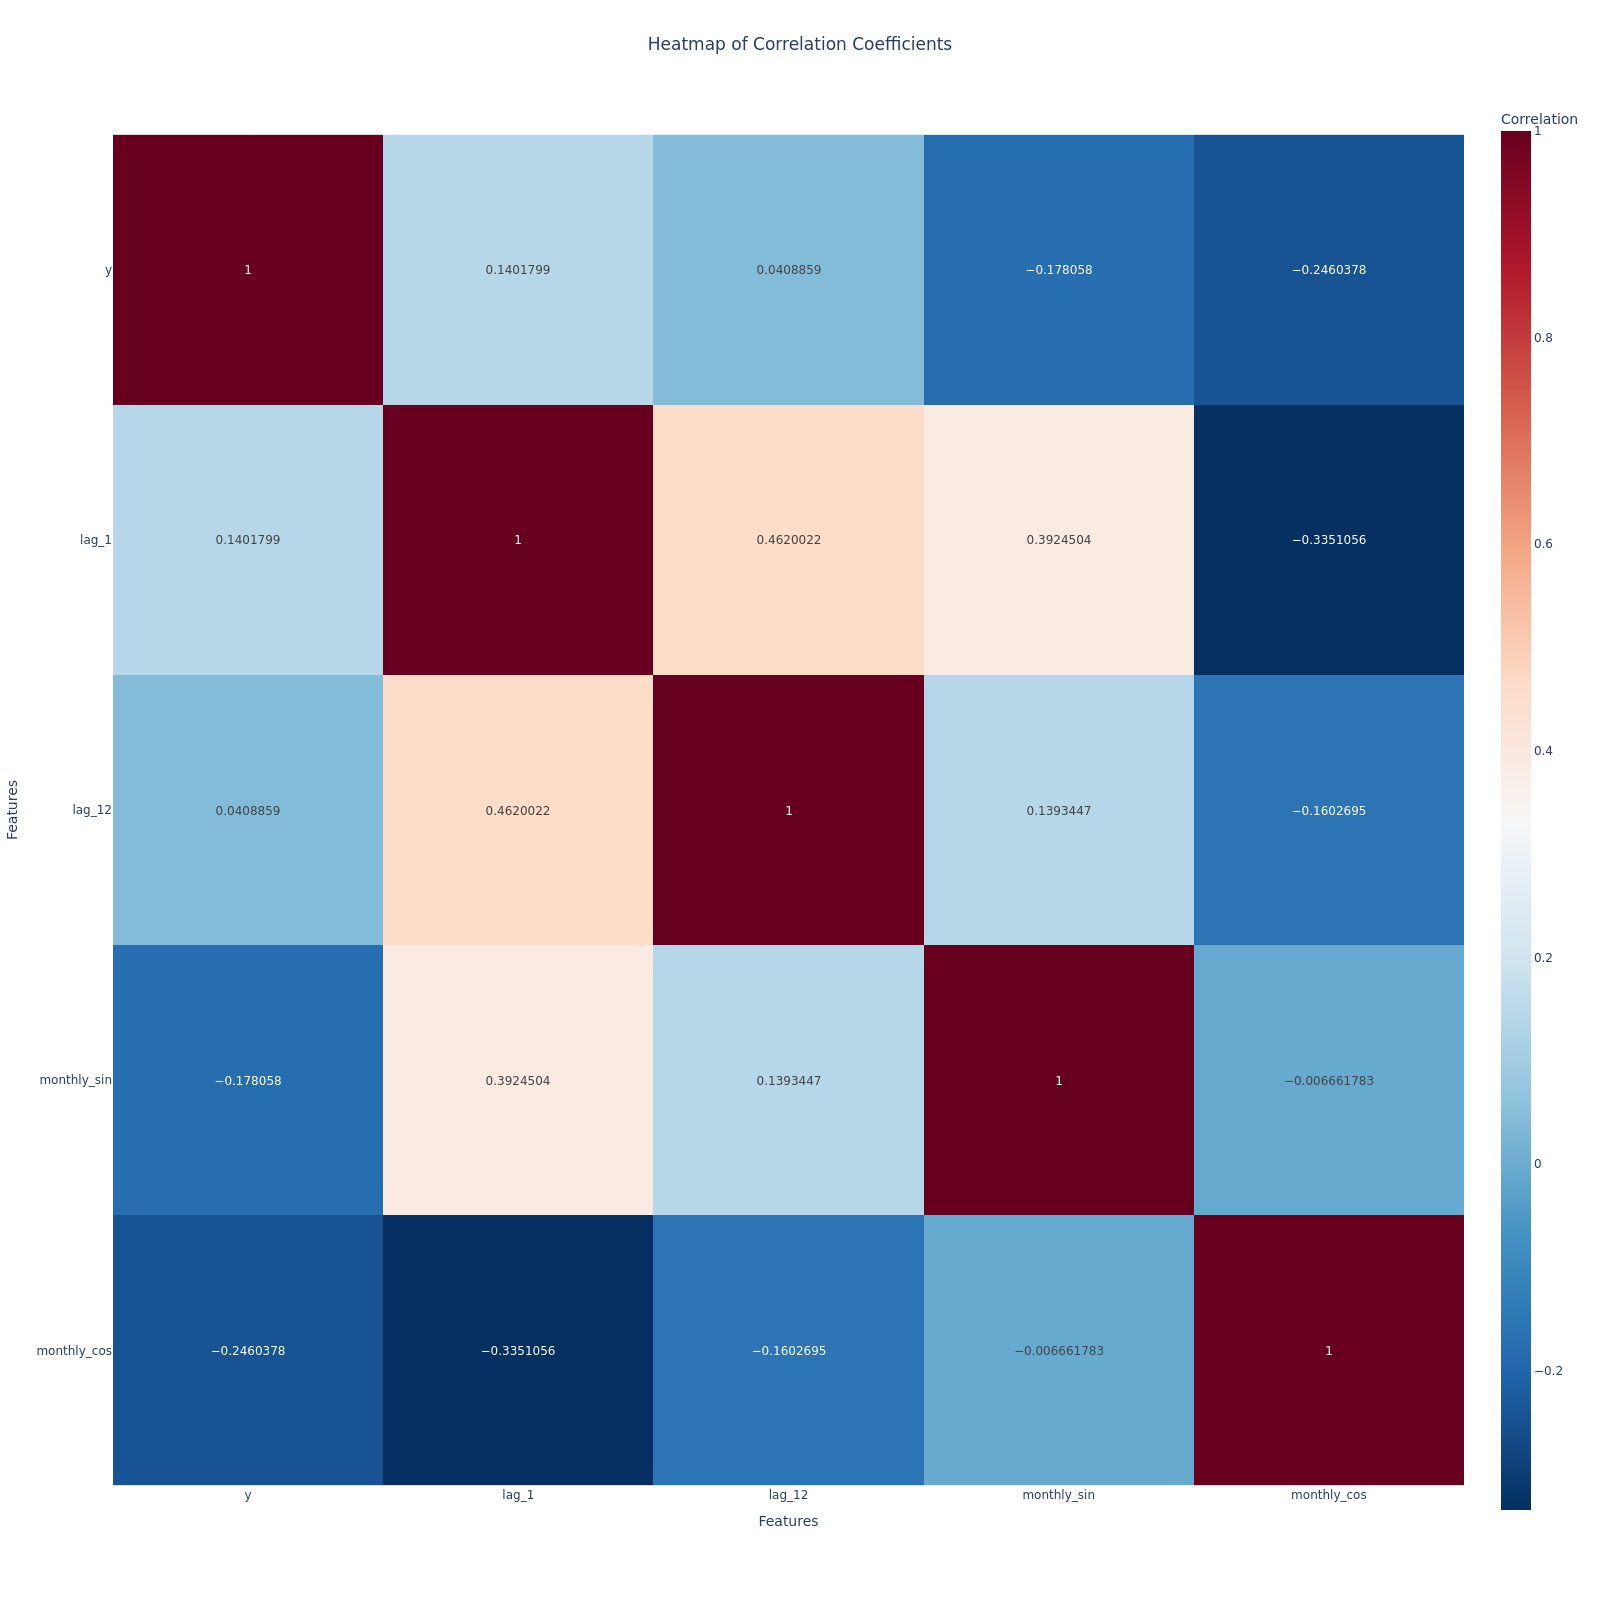

In [21]:
corr_heatmap(df[df.columns[2:]], fig_type="png")

# Modelagem (Decomposição + Modelagem Residual)

1. modelo estatístico + ML residual
2. ver como fazer Tendência aditivia, sazonalidade multiplicativa
3. ver como fazer tendência aditiva, sazonalidade aditiva